<a href="https://colab.research.google.com/github/yusufunlu/DeepLearningExamples/blob/main/Phase_1_eff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMPORTS

In [ ]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns
sns.set(style = "darkgrid")

In [ ]:
os.environ['KAGGLE_USERNAME'] = "yusufunlu" # username from the json file
os.environ['KAGGLE_KEY'] = "6d464cc201a36e8743ed8fbaa39b235f" # key from the json file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!kaggle datasets download -d hgunraj/covidxct

100% 28.7G/28.7G [05:10<00:00, 107MB/s] 
100% 28.7G/28.7G [05:10<00:00, 99.3MB/s]


In [ ]:
#!unzip covidxct.zip

Streaming output truncated to the last 5000 lines.
  inflating: 2A_images/volume-covid19-A-0382_ct-0028.png  
  inflating: 2A_images/volume-covid19-A-0382_ct-0035.png  
  inflating: 2A_images/volume-covid19-A-0382_ct-0037.png  
  inflating: 2A_images/volume-covid19-A-0382_ct-0042.png  
  inflating: 2A_images/volume-covid19-A-0382_ct-0043.png  
  inflating: 2A_images/volume-covid19-A-0382_ct-0045.png  
  inflating: 2A_images/volume-covid19-A-0383_0-0032.png  
  inflating: 2A_images/volume-covid19-A-0383_0-0033.png  
  inflating: 2A_images/volume-covid19-A-0383_1_ct-0018.png  
  inflating: 2A_images/volume-covid19-A-0383_1_ct-0019.png  
  inflating: 2A_images/volume-covid19-A-0383_1_ct-0020.png  
  inflating: 2A_images/volume-covid19-A-0383_1_ct-0021.png  
  inflating: 2A_images/volume-covid19-A-0383_1_ct-0022.png  
  inflating: 2A_images/volume-covid19-A-0383_1_ct-0023.png  
  inflating: 2A_images/volume-covid19-A-0383_1_ct-0024.png  
  inflating: 2A_images/volume-covid19-A-0383_1_ct-00

In [ ]:
!ls drive/MyDrive/covid/

2A_images     metadata.csv	     train_COVIDx_CT-2A.txt
covidxct.zip  test_COVIDx_CT-2A.txt  val_COVIDx_CT-2A.txt


In [ ]:
#!cp *.txt drive/MyDrive/covid/

In [ ]:
#!cp metadata.csv drive/MyDrive/covid/

## SETTING UP PARAMETERS AND DIRECTORIES

In [ ]:
#dataset_path= 'drive/MyDrive/covid'
dataset_path= '.'
SEED = 12
IMG_HEIGHT = 64
IMG_WIDTH = 64
DIM = (IMG_HEIGHT, IMG_WIDTH)
TRAIN_SET= 143778
VALID_SET= 25486
EPOCHS = 10
BS = 32
n = 10000
LR = 0.0001
label_file_train = dataset_path+"/train_COVIDx_CT-2A.txt"
label_file_valid = dataset_path+"/val_COVIDx_CT-2A.txt"

In [ ]:
def load_labels(label_file):
    """Loads image filenames, classes, and bounding boxes"""
    fnames, classes, bboxes = [], [], []
    with open(label_file, 'r') as f:
        for line in f.readlines():
            fname, cls, xmin, ymin, xmax, ymax = line.strip('\n').split()
            fnames.append(fname)
            classes.append(int(cls))
            bboxes.append((int(xmin), int(ymin), int(xmax), int(ymax)))
    fnames = [dataset_path + "/2A_images/" + fname for fname in fnames]
    fnames = np.array(fnames)
    classes = np.array(classes)
    return fnames, classes, bboxes

def index_generator(fnames , SET):
    """Genrated random index of a particular class"""
    np.random.seed(SEED)
    index = np.random.randint(1,len(fnames),size = SET)
    return index 

def numberofclasses(classes, index):
    class0 = len((np.where(classes[index]==0))[0])
    class1 = len((np.where(classes[index]==1))[0])
    class2 = len((np.where(classes[index]==2))[0])
    return class0  , class1, class2
def dataframe_generator(train_index , valid_index , classes_train , classes_valid ):
    """Returns 1 dataframes of datasets distribution"""
    index = ["Normal" , "Pneumonia" , "COIVD -19"]
    train_DF = numberofclasses(classes_train, train_index)
    valid_DF = numberofclasses(classes_valid, valid_index)
    df = pd.DataFrame({'train': train_DF ,'valid' : valid_DF} , index = index)
    return df
def train_index_updater(classes_train , train_index,n ):
    """Updates train_index for class balance"""
    np.random.seed(SEED)
    class0_train = np.where(classes_train[train_index]==0)[0]
    class1_train = np.where(classes_train[train_index]==1)[0]
    class2_train = np.where(classes_train[train_index]==2)[0]
    class0 =train_index[class0_train]
    class1 = train_index[class1_train]
    np.random.seed(SEED)
    class22 = np.random.choice(class2_train , n)
    class2 = train_index[class22]
    train_index_updated = np.concatenate((class0 , class1 , class2))
    np.random.shuffle(train_index_updated)
    return train_index_updated

def data_constructor(filepath, classes , dim_size ,index  ,bboxes , interpolation = cv2.INTER_AREA , intensify =True):
    """Constructs and splits X and Y for training , validtion and test"""
    np.random.seed(SEED)
    y = np.array(classes[index])
    x = []
    print("filepath out: "+filepath[0])
    for i in index:
        #print("filepath in: "+filepath[i])
        img  = cv2.imread(filepath[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        x1,y1,x2,y2 = bboxes[i]
        img = img[y1:y2,x1:x2]
        img = cv2.resize(img, dim_size , interpolation = interpolation)
        x.append(img)
    
    x = np.array(x)
    if intensify == True:
        x= x/255
    return x , y 

NameError: ignored

## LOADING DATA

In [ ]:
fnames_train , classes_train ,bboxes_train = load_labels(label_file_train) # load the training data
fnames_valid , classes_valid ,bboxes_valid = load_labels(label_file_valid) # load the validation data
train_index = index_generator(fnames_train , TRAIN_SET)
valid_index = index_generator(fnames_valid , VALID_SET)
train_index_updated = train_index_updater(classes_train,train_index,n )
df = dataframe_generator(train_index_updated , valid_index , classes_train , classes_valid)
df.plot.bar( title = "Image Distribution" );

In [ ]:
#!pip install -q --upgrade ipython
#!pip install -q --upgrade ipykernel

## Loading Training and Validation Images

In [ ]:
x_train, y_train = data_constructor(fnames_train,classes_train, DIM , index  =train_index_updated ,bboxes = bboxes_train )

In [ ]:
x_valid , y_valid= data_constructor(fnames_valid,classes_valid, DIM, index  =valid_index , bboxes = bboxes_valid)

## Pre-Processing

Preprocesses a tensor or Numpy array encoding a batch of images.
Each Keras Application expects a specific kind of input preprocessing. For DenseNet, call tf.keras.applications.densenet.preprocess_input on your inputs before passing them to the model.
Mobinet scaled and returned to 0 between 1 the input with respect to the ImageNet dataset. I am not sure for scale limits of densenet.preprocess_input but I saw -2.1 to 2.1 values.

In [ ]:
#(111599, 128, 128, 3)
x_train = tf.keras.applications.densenet.preprocess_input(x_train)
x_valid = tf.keras.applications.densenet.preprocess_input(x_valid)

In [ ]:
print(x_train.shape)

In [ ]:
#number of classes reduced to 2
#sign class 2 as 1 and class 1 as 0
for i in range(len(y_train)):
    if y_train[i] ==1:
        y_train[i]=0
    if y_train[i] ==2:
        y_train[i]=1
for i in range(len(y_valid)):
    if y_valid[i] ==1:
        y_valid[i]=0
    if y_valid[i]==2:
        y_valid[i]=1

In [ ]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,zoom_range=0.05,width_shift_range=0.2 ,height_shift_range=0.1,shear_range=0.05)## ENTER YOUR AUG HERE
train_generator = data_generator.flow(x_train, y_train, BS)
spe = x_train.shape[0] // BS

In [ ]:
spe

## MODEL DESIGN

In [ ]:
from tensorflow.keras.applications import DenseNet201,ResNet152,EfficientNetV2L
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding, LSTM

In [ ]:
# pretrained resnet152 or densenet201 architecture
dense_base_model = DenseNet201(include_top=False,weights="imagenet",input_shape=(IMG_HEIGHT,IMG_HEIGHT,3))
eff_base_model = EfficientNetV2L(include_top=False,weights="imagenet",input_shape=(IMG_HEIGHT,IMG_HEIGHT,3))

model= tf.keras.Sequential()
model.add(eff_base_model) # 4x4x2048
model.add(GlobalAveragePooling2D()) # 1x2048 
model.add(Dense(64,activation=('relu'))) # 1x64
model.add(Dropout(.2)) # applies regularization, prevents overfitting
model.add(Dense(1,activation=('sigmoid'))) # classification layer

In [ ]:
model.summary()

In [ ]:
#LR is learning rate
#if LR is smaller it get slower but can get into details of learning
#if LR is too big there is a posilibilty for reflecting forever and can't learn everything or can take too long time
model.compile(optimizer=tf.keras.optimizers.SGD(LR),
              loss = "binary_crossentropy",
              metrics = ["accuracy"]) # derive from binary crossentropy

In [ ]:
##stocastic gradient descent derive from binary_crossentropy, when it finds the direction it goes in that direction as LR size
from tensorflow.keras.callbacks import ModelCheckpoint
modelsdir = "models"
checkpoint = ModelCheckpoint(filepath = modelsdir + "/SGD.{epoch:02d}-{val_accuracy:.4f}.h5" ,
                             monitor= "val_accuracy" , 
                             mode = "max",
                            verbose = 0,
                            save_best_only=True)

In [ ]:
EPOCHS

In [29]:
#batch size is samples per iteration
#batch size could be 8,16,32,64,etc... depending on GPU RAM or TPU RAM. It is not always good for a bigger batch size even if we have a lot memory. Cuz if batch size is big sometimes it doesn't learn
r = model.fit(train_generator , validation_data=(x_valid, y_valid), steps_per_epoch = spe ,epochs=EPOCHS ,verbose = 1 )

Epoch 1/10
2237/2237 [==============================] - 3791s 2s/step - loss: 0.6039 - accuracy: 0.6946 - val_loss: 0.6860 - val_accuracy: 0.4923
Epoch 2/10
2237/2237 [==============================] - 3809s 2s/step - loss: 0.4394 - accuracy: 0.8557 - val_loss: 0.6245 - val_accuracy: 0.7555
Epoch 3/10
2237/2237 [==============================] - 3831s 2s/step - loss: 0.4097 - accuracy: 0.8598 - val_loss: 0.8555 - val_accuracy: 0.7555
Epoch 4/10
2237/2237 [==============================] - 4187s 2s/step - loss: 0.4040 - accuracy: 0.8596 - val_loss: 0.7335 - val_accuracy: 0.7499
Epoch 5/10
2237/2237 [==============================] - 3999s 2s/step - loss: 0.3855 - accuracy: 0.8600 - val_loss: 0.6087 - val_accuracy: 0.7528
Epoch 6/10
2237/2237 [==============================] - 4056s 2s/step - loss: 0.3826 - accuracy: 0.8600 - val_loss: 0.6860 - val_accuracy: 0.7555
Epoch 7/10
2237/2237 [==============================] - 3901s 2s/step - loss: 0.3740 - accuracy: 0.8600 - val_loss: 0.7747 -

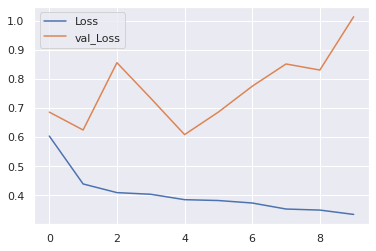

In [30]:
plt.plot(r.history["loss"], label= "Loss")
plt.plot(r.history["val_loss"], label = "val_Loss")
plt.legend();

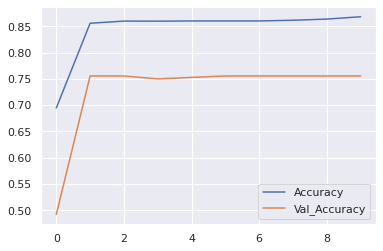

In [31]:
plt.plot(r.history["accuracy"] ,label = "Accuracy")
plt.plot(r.history["val_accuracy"] ,label = "Val_Accuracy")
plt.legend();

In [59]:
#model fitting history
#we save as csv for later on investigating
pd.DataFrame(r.history).to_csv("eff-1.csv",index=False)

In [57]:
model.save("eff-1.h5") # save the weights

## MORE TRAINING

In [34]:
LR = 0.001
EPOCHS = 3

In [35]:
#it sign as hasta for lest than 0.5
#we need binary results used binary_crossentropy
model.compile(optimizer=tf.keras.optimizers.SGD(LR),
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

In [36]:
#after each epoch if val_accuracy is max then save it.
#save accuracy to csv but callback weights too. 
from tensorflow.keras.callbacks import ModelCheckpoint
modelsdir = "models"
checkpoint = ModelCheckpoint(filepath = modelsdir + "/(mt)SGD.{epoch:02d}-{val_accuracy:.4f}.h5" ,
                             monitor= "val_accuracy" , 
                             mode = "max",
                            verbose = 0,
                            save_best_only=True)

In [37]:
s = model.fit(train_generator , validation_data=(x_valid, y_valid), steps_per_epoch = spe ,epochs=EPOCHS, callbacks = [checkpoint] ,verbose = 1 )

Epoch 1/3
2237/2237 [==============================] - 4187s 2s/step - loss: 0.4137 - accuracy: 0.8569 - val_loss: 0.6039 - val_accuracy: 0.7557
Epoch 2/3
2237/2237 [==============================] - 3994s 2s/step - loss: 0.3143 - accuracy: 0.8790 - val_loss: 0.5690 - val_accuracy: 0.7555
Epoch 3/3
2237/2237 [==============================] - 4028s 2s/step - loss: 0.2739 - accuracy: 0.8952 - val_loss: 1409.3744 - val_accuracy: 0.7555


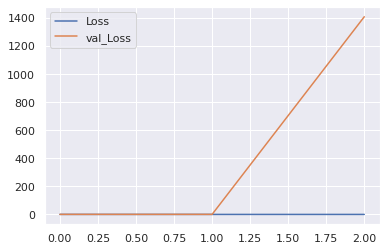

In [38]:
plt.plot(s.history["loss"], label= "Loss")
plt.plot(s.history["val_loss"], label = "val_Loss")
plt.legend();

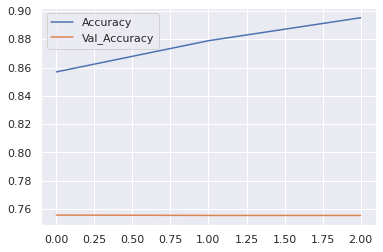

In [39]:
plt.plot(s.history["accuracy"] ,label = "Accuracy")
plt.plot(s.history["val_accuracy"] ,label = "Val_Accuracy")
plt.legend();

In [60]:
pd.DataFrame(s.history).to_csv("eff-2.csv",index=False)

In [62]:
model.save("eff-2.h5")

In [63]:
!ls

2A_images     eff-1.csv  eff-2.h5     test_COVIDx_CT-2A.txt
covidxct.zip  eff-1.h5	 models       train_COVIDx_CT-2A.txt
drive	      eff-2.csv  sample_data  val_COVIDx_CT-2A.txt


### Loading Combined CSV for plots

In [64]:
phase1_history = pd.read_csv("eff-1.csv")
phase2_history = pd.read_csv("eff-2.csv")
history = pd.concat([phase1_history,phase2_history],ignore_index=True)
pd.DataFrame(history).to_csv('eff-combined.csv',index=False)

In [65]:
history = pd.read_csv("eff-combined.csv")

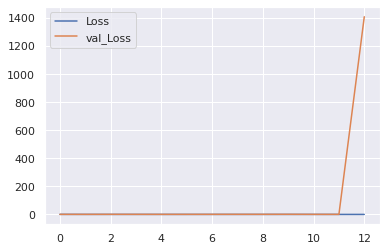

In [66]:
plt.plot(history["loss"], label= "Loss")
plt.plot(history["val_loss"], label = "val_Loss")
plt.legend();

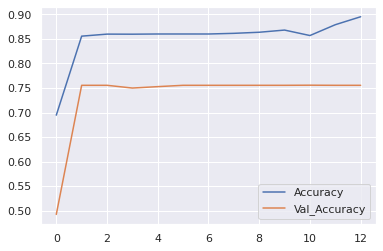

In [67]:
plt.plot(history["accuracy"] ,label = "Accuracy")
plt.plot(history["val_accuracy"] ,label = "Val_Accuracy")
plt.legend();

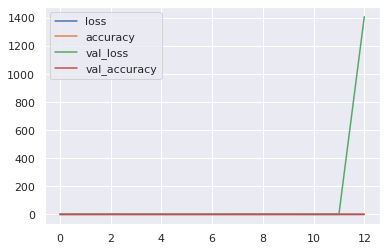

In [68]:
history.plot();

In [69]:
!mkdir drive/MyDrive/covid/phase1results

mkdir: cannot create directory ‘drive/MyDrive/covid/phase1results’: File exists


In [70]:
!cp eff-1.h5 eff-2.csv eff-2.h5 eff.csv eff-combined.csv drive/MyDrive/covid/phase1results

cp: cannot stat 'eff.csv': No such file or directory


In [73]:
!cp *.csv *.h5 drive/MyDrive/covid/phase1results

In [75]:
!cp *.csv drive/MyDrive/covid/phase1results/